\newpage

# Supplemental Material

- Note: GitHub Copilot was used to assist with code generation and error handling.

# Plots

# Imports

In [9]:
# Core
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing & Splitting
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from metric_learn import LMNN  # Metric learning, optional

# Metrics & Evaluation
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    confusion_matrix,
    classification_report,
    roc_curve,
    roc_auc_score
)


In [10]:
df = pd.read_csv("spotify_churn_dataset.csv")
df = df.drop(columns=['user_id'])

# Exploratory Data analysis

In [11]:
df.isna().sum()
df.shape
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   gender                 8000 non-null   object 
 1   age                    8000 non-null   int64  
 2   country                8000 non-null   object 
 3   subscription_type      8000 non-null   object 
 4   listening_time         8000 non-null   int64  
 5   songs_played_per_day   8000 non-null   int64  
 6   skip_rate              8000 non-null   float64
 7   device_type            8000 non-null   object 
 8   ads_listened_per_week  8000 non-null   int64  
 9   offline_listening      8000 non-null   int64  
 10  is_churned             8000 non-null   int64  
dtypes: float64(1), int64(6), object(4)
memory usage: 687.6+ KB


,age,listening_time,songs_played_per_day,skip_rate,ads_listened_per_week,offline_listening,is_churned
count,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000
mean,37.662125,154.068250,50.127250,0.300127,6.943875,0.747750,0.258875
std,12.740359,84.015596,28.449762,0.173594,13.617953,0.434331,0.438044
min,16.000000,10.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,26.000000,81.000000,25.000000,0.150000,0.000000,0.000000,0.000000
50%,38.000000,154.000000,50.000000,0.300000,0.000000,1.000000,0.000000
75%,49.000000,227.000000,75.000000,0.450000,5.000000,1.000000,1.000000
max,59.000000,299.000000,99.000000,0.600000,49.000000,1.000000,1.000000


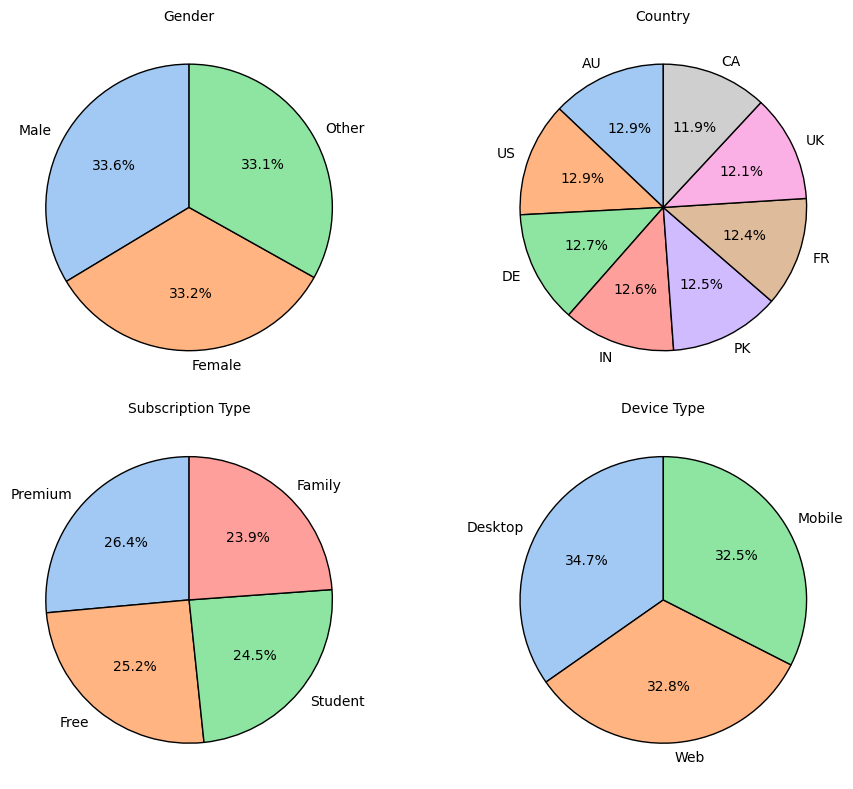

In [12]:
# Select categorical columns
categorical_cols = df.select_dtypes(include=['object', 'category']).columns

# Plot pie charts in 2x2 grids
for i in range(0, len(categorical_cols), 4):
    plt.figure(figsize=(10, 8))
    for j, col in enumerate(categorical_cols[i:i+4], 1):
        plt.subplot(2, 2, j)
        df[col].value_counts().plot(
            kind='pie',
            autopct='%1.1f%%',
            startangle=90,
            colors=sns.color_palette("pastel"),
            wedgeprops={'edgecolor': 'k'}
        )
        plt.title(col.replace("_", " ").title(), fontsize=10)
        plt.ylabel('')
    plt.tight_layout()
    plt.savefig("pie.png", dpi=300, bbox_inches='tight')
    plt.show()



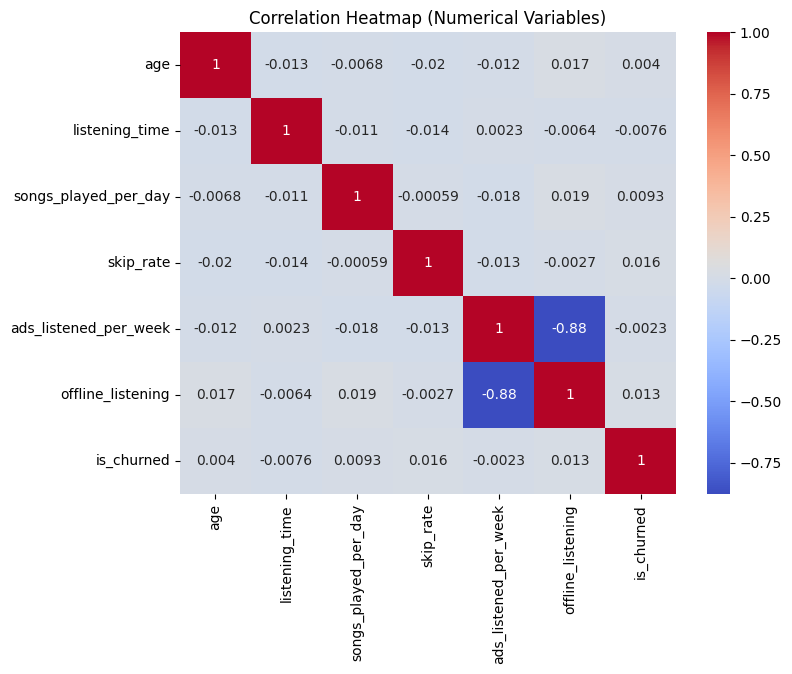

In [13]:
plt.figure(figsize=(8,6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap (Numerical Variables)")
plt.savefig("corr.png", dpi=300, bbox_inches='tight')
plt.show()


# Data Splitting

In [14]:
y = df['is_churned']

# Features: drop the target
X = df.drop(columns=['is_churned'])

# Optional: check the shapes
print("X shape:", X.shape)
print("y shape:", y.shape)


X shape: (8000, 10)
y shape: (8000,)


In [15]:
# First, spliting off the test set (20%)
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Then, spliting the remaining 80% into training and validation (75% train, 25% val → 60/20 overall)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp
)

print("Training size:", X_train.shape[0])
print("Validation size:", X_val.shape[0])
print("Test size:", X_test.shape[0])


Training size: 4800
Validation size: 1600
Test size: 1600


# Scalling and Encoding

In [16]:
# 3. One-hot encode categorical variables directly (returns DataFrame)
X_train_final = pd.get_dummies(X_train, dtype=int, columns=X_train.select_dtypes
                               (include=['object']).columns, drop_first=False)
X_val_final = pd.get_dummies(X_val, dtype=int,columns=X_val.select_dtypes
                             (include=['object']).columns, drop_first=False)
X_test_final = pd.get_dummies(X_test, dtype=int,columns=X_test.select_dtypes
                              (include=['object']).columns, drop_first=False)

# 4. Align columns (in case some categories are missing in val/test)
X_val_final = X_val_final.reindex(columns=X_train_final.columns, fill_value=0)
X_test_final = X_test_final.reindex(columns=X_train_final.columns, fill_value=0)

# 5. Shapes
print("X_train:", X_train_final.shape)
print("X_val:", X_val_final.shape)
print("X_test:", X_test_final.shape)


X_train: (4800, 24)
X_val: (1600, 24)
X_test: (1600, 24)


In [17]:
# Columns you want to scale
scale_cols = ['age', 'listening_time', 'songs_played_per_day', 'skip_rate']

scaler = StandardScaler()

# Copy so we don't overwrite original data
X_train_scaled = X_train_final.copy()
X_val_scaled   = X_val_final.copy()
X_test_scaled  = X_test_final.copy()

# Fit on train only
X_train_scaled[scale_cols] = scaler.fit_transform(X_train_final[scale_cols])
X_val_scaled[scale_cols]   = scaler.transform(X_val_final[scale_cols])
X_test_scaled[scale_cols]  = scaler.transform(X_test_final[scale_cols])


# KNN

In [18]:
# Range of k values to try
k_values = range(1, 21)  # try k from 1 to 20
val_accuracies = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)
    y_val_pred = knn.predict(X_val_scaled)
    acc = accuracy_score(y_val, y_val_pred)
    val_accuracies.append(acc)

# Find best k
best_k = k_values[np.argmax(val_accuracies)]
print("Best k based on validation set:", best_k)


Best k based on validation set: 17


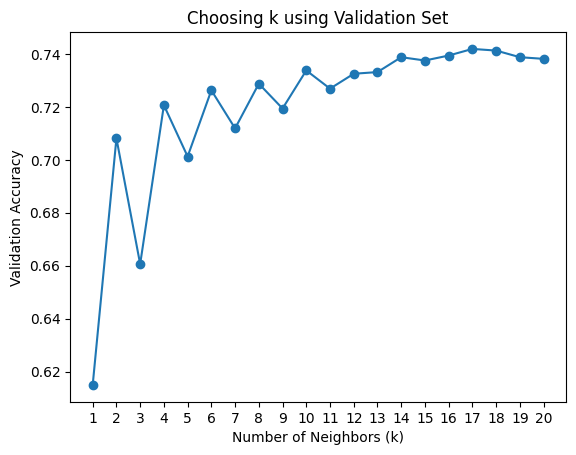

In [19]:
plt.plot(k_values, val_accuracies, marker='o')
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("Validation Accuracy")
plt.title("Choosing k using Validation Set")
plt.xticks(k_values)
plt.show()


Optimal probability cutoff: 0.286


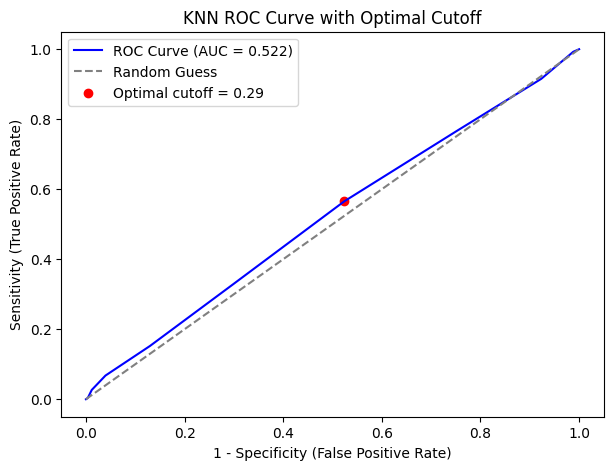

Confusion Matrix:
[[565 621]
 [180 234]]

Accuracy: 0.499
Precision: 0.274
Misclassification Error: 0.501
Sensitivity (Recall): 0.565
Specificity: 0.476
F1-Score: 0.369
AUC: 0.522


In [20]:
# --- Train best KNN on combined train+val and test it ---
best_k = 14  # selected from validation performance
knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(np.vstack((X_train_scaled, X_val_scaled)), np.hstack((y_train, y_val)))
y_test_prob = knn.predict_proba(X_test_scaled)[:, 1]

# --- ROC and optimal cutoff ---
fpr, tpr, thresholds = roc_curve(y_test, y_test_prob)
optimal_idx = (tpr - fpr).argmax()
optimal_cutoff = thresholds[optimal_idx]
print(f"Optimal probability cutoff: {optimal_cutoff:.3f}")

# --- Plot ROC curve ---
plt.figure(figsize=(7,5))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc_score(y_test, y_test_prob):.3f})', color='blue')
plt.plot([0, 1], [0, 1], '--', color='gray', label='Random Guess')
plt.scatter(fpr[optimal_idx], tpr[optimal_idx], color='red', label=f'Optimal cutoff = {optimal_cutoff:.2f}')
plt.title("KNN ROC Curve with Optimal Cutoff")
plt.xlabel("1 - Specificity (False Positive Rate)")
plt.ylabel("Sensitivity (True Positive Rate)")
plt.legend()
plt.show()

# --- Apply optimal cutoff and compute metrics ---
y_test_pred = (y_test_prob >= optimal_cutoff).astype(int)
cm = confusion_matrix(y_test, y_test_pred)
tn, fp, fn, tp = cm.ravel()

print("Confusion Matrix:")
print(cm)

accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = precision_score(y_test, y_test_pred)
misclassification_error = 1 - accuracy
recall = recall_score(y_test, y_test_pred)  # Sensitivity
specificity = tn / (tn + fp)
f1 = f1_score(y_test, y_test_pred)
auc = roc_auc_score(y_test, y_test_prob)

print(f"\nAccuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Misclassification Error: {misclassification_error:.3f}")
print(f"Sensitivity (Recall): {recall:.3f}")
print(f"Specificity: {specificity:.3f}")
print(f"F1-Score: {f1:.3f}")
print(f"AUC: {auc:.3f}")


# Logistic Regression

In [21]:
C_values = np.logspace(-4, 4, 25)
accs, f1s, aucs = [], [], []

for C in C_values:
    clf = LogisticRegression(C=C, solver='liblinear', class_weight='balanced', max_iter=1000)
    clf.fit(X_train_scaled, y_train)
    y_val_prob = clf.predict_proba(X_val_scaled)[:,1]  # if binary
    y_val_pred = (y_val_prob >= 0.5).astype(int)

    accs.append(accuracy_score(y_val, y_val_pred))
    f1s.append(f1_score(y_val, y_val_pred, average='binary'))  # change average for multiclass
    try:
        aucs.append(roc_auc_score(y_val, y_val_prob))
    except Exception:
        aucs.append(np.nan)

# report best by different metrics
best_acc = C_values[np.nanargmax(accs)]
best_f1  = C_values[np.nanargmax(f1s)]
best_auc = C_values[np.nanargmax(aucs)]

print("Best C (acc):", best_acc, max(accs))
print("Best C (f1):", best_f1, max(f1s))
print("Best C (auc):", best_auc, max(aucs))


Best C (acc): 0.1 0.5225
Best C (f1): 0.00046415888336127773 0.35294117647058826
Best C (auc): 1.0 0.5150345007372649


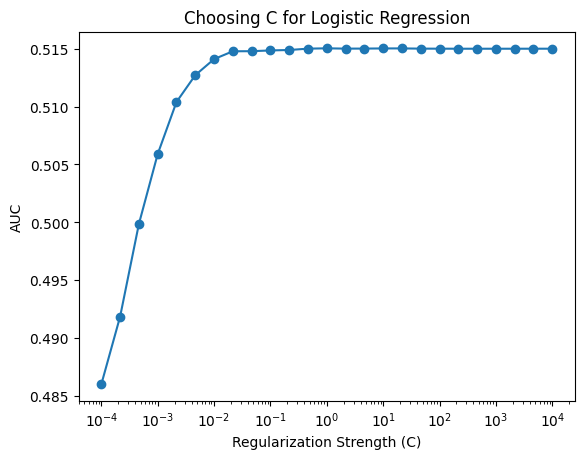

In [22]:
import matplotlib.pyplot as plt

plt.semilogx(C_values, aucs, marker='o')
plt.xlabel("Regularization Strength (C)")
plt.ylabel("AUC")
plt.title("Choosing C for Logistic Regression")
plt.show()

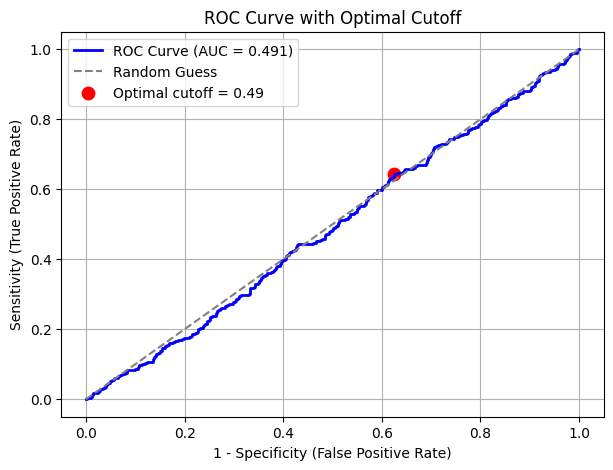


=== Logistic Regression Test Performance ===
Accuracy: 0.459
Misclassification Error: 0.541
Sensitivity (TPR): 0.589
Specificity (TNR): 0.414
Confusion Matrix:
 [[491 695]
 [170 244]]


In [23]:
# Train a final model (use best C or just C=1)
clf = LogisticRegression(C=1, solver='liblinear', class_weight='balanced', max_iter=1000)
clf.fit(X_train_scaled, y_train)

# Predict probabilities on validation or test set
y_test_prob = clf.predict_proba(X_test_scaled)[:, 1]

# Compute ROC curve values
fpr, tpr, thresholds = roc_curve(y_test, y_test_prob)
auc = roc_auc_score(y_test, y_test_prob)

# Find optimal cutoff index
optimal_idx = (tpr - fpr).argmax()
optimal_cutoff = thresholds[optimal_idx]

# Plot ROC curve
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {auc:.3f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random Guess')

# Mark optimal point
plt.scatter(fpr[optimal_idx], tpr[optimal_idx], color='red', s=80,
            label=f'Optimal cutoff = {optimal_cutoff:.2f}')

# Labels and legend
plt.xlabel('1 - Specificity (False Positive Rate)')
plt.ylabel('Sensitivity (True Positive Rate)')
plt.title('ROC Curve with Optimal Cutoff')
plt.legend()
plt.grid(True)
plt.show()

# Classify based on cutoff
y_test_pred = (y_test_prob >= 0.49).astype(int)

# Confusion matrix and performance metrics
cm = confusion_matrix(y_test, y_test_pred)
tn, fp, fn, tp = cm.ravel()

accuracy = accuracy_score(y_test, y_test_pred)
error_rate = 1 - accuracy
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

print("\n=== Logistic Regression Test Performance ===")
print(f"Accuracy: {accuracy:.3f}")
print(f"Misclassification Error: {error_rate:.3f}")
print(f"Sensitivity (TPR): {sensitivity:.3f}")
print(f"Specificity (TNR): {specificity:.3f}")
print("Confusion Matrix:\n", cm)


In [24]:
coef_df = pd.DataFrame({
    'Feature': X_train_scaled.columns,
    'Coefficient': clf.coef_.ravel()
})
coef_df['AbsCoefficient'] = np.abs(coef_df['Coefficient'])
coef_df.sort_values('AbsCoefficient', ascending=False)


,Feature,Coefficient,AbsCoefficient
10,country_CA,-0.165776,0.165776
18,subscription_type_Free,-0.144746,0.144746
12,country_FR,0.135067,0.135067
13,country_IN,-0.127658,0.127658
5,offline_listening,0.082171,0.082171
23,device_type_Web,-0.075653,0.075653
2,songs_played_per_day,0.068689,0.068689
14,country_PK,0.068126,0.068126
11,country_DE,0.059032,0.059032
7,gender_Male,-0.055068,0.055068


# KNN using LMNN

Best k (with LMNN) based on validation set: 18


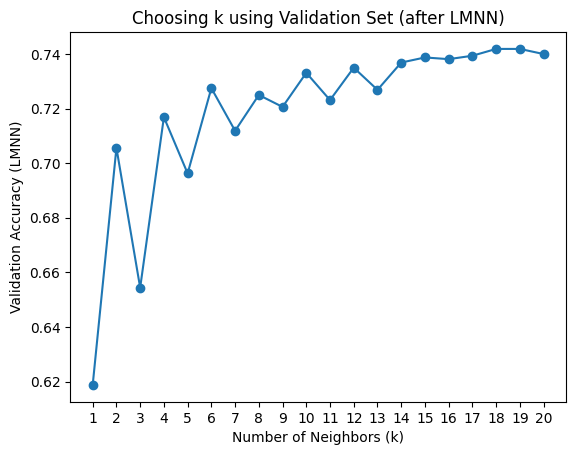

In [25]:
# Train LMNN on training data ---
lmnn = LMNN(k=5, learn_rate=1e-6, max_iter=200)
lmnn.fit(X_train_scaled, y_train)

# Transform train, val, test sets ---
X_train_lmnn = lmnn.transform(X_train_scaled)
X_val_lmnn   = lmnn.transform(X_val_scaled)
X_test_lmnn  = lmnn.transform(X_test_scaled)

# Select best k using validation accuracy ---
k_values = range(1, 21)
val_accuracies = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_lmnn, y_train)
    y_val_pred = knn.predict(X_val_lmnn)
    acc = accuracy_score(y_val, y_val_pred)
    val_accuracies.append(acc)

best_k = k_values[np.argmax(val_accuracies)]
print("Best k (with LMNN) based on validation set:", best_k)

# Plot validation accuracy vs k ---
plt.plot(k_values, val_accuracies, marker='o')
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("Validation Accuracy (LMNN)")
plt.title("Choosing k using Validation Set (after LMNN)")
plt.xticks(k_values)
plt.show()


In [26]:

# Train final KNN (best_k) on combined train+val and test it ---
knn = KNeighborsClassifier(n_neighbors=12)
knn.fit(np.vstack((X_train_lmnn, X_val_lmnn)), np.hstack((y_train, y_val)))

# Predict probabilities on test set ---
y_test_prob = knn.predict_proba(X_test_lmnn)[:, 1]

# ROC curve and optimal cutoff ---
fpr, tpr, thresholds = roc_curve(y_test, y_test_prob)
auc = roc_auc_score(y_test, y_test_prob)
optimal_idx = (tpr - fpr).argmax()
optimal_cutoff = thresholds[optimal_idx]
print(f"AUC (LMNN + KNN): {auc:.3f}")
print(f"Optimal probability cutoff: {optimal_cutoff:.3f}")

# Confusion matrix using optimal cutoff ---
y_test_pred = (y_test_prob >= optimal_cutoff).astype(int)
cm = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix (LMNN + KNN):")
print(cm)

# Compute performance metrics ---
tn, fp, fn, tp = cm.ravel()

accuracy = (tp + tn) / (tp + tn + fp + fn)
misclassification_error = 1 - accuracy
precision = tp / (tp + fp) if (tp + fp) != 0 else 0
recall = tp / (tp + fn) if (tp + fn) != 0 else 0  # Sensitivity
specificity = tn / (tn + fp) if (tn + fp) != 0 else 0
f1_score_val = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
auc_val = roc_auc_score(y_test, y_test_prob)

# Print metrics ---
print(f"\nAccuracy: {accuracy:.3f}")
print(f"Misclassification Error: {misclassification_error:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Sensitivity (Recall): {recall:.3f}")
print(f"Specificity: {specificity:.3f}")
print(f"F1-Score: {f1_score_val:.3f}")
print(f"AUC: {auc_val:.3f}")

AUC (LMNN + KNN): 0.524
Optimal probability cutoff: 0.333
Confusion Matrix (LMNN + KNN):
[[723 463]
 [232 182]]

Accuracy: 0.566
Misclassification Error: 0.434
Precision: 0.282
Sensitivity (Recall): 0.440
Specificity: 0.610
F1-Score: 0.344
AUC: 0.524


In [ ]:
dew